> Note: Please read Question 17 at the end of this document carefully before you start your work! You will need to provide a detailed discussion of how you used GenAI for this assignment so make sure to keep notes, create screenshots, etc. so you keep track of your “discussions” as you go through each question.

> Note: Please also review the assignment PDF in this assignment. That document has the most details about what you are expected to do to complete this individual assignment. Good luck! 

# Tuango - Targeting Mobile App Messages

Prepare "Tuango: Targeting Mobile Push Messages" for class discussion and as an individual assignment and submit the assignment through GitHub. Detailed instructions are available on Canvas (tuango.pdf). See the assignment on Canvas for the "invitation" to get the repo. Once you accepted the invitation, you should see the repo at the page below.

See the assignment on Canvas for the "invitation" to get the repo. Once you accepted the invitation, you should see the repo at the page below.

<https://github.com/rady-msba>

Add code and your answers for all questions to the tuango.ipynb. When you are done with this individual assignment, save your code and commit and push the results to GitHub. Of course you can commit and push code as often as you like, but only before the due date. View the video linked below to refresh your memory on how to clone and push repos.

https://youtu.be/w6yzFv44CMc 

Add text motivating your work in Markdown format. Markdown is a simple formatting syntax for authoring HTML. For more details on using markdown go to http://commonmark.org/help/ for a 10-minute interactive Markdown tutorial

Note that your python code must be fully "reproducible". That is, your code must without errors on my (or the TAs) computer. There are will not be any explicit tests for this assignment to confirm if your answers are (not) correct. However, the system will run your code and it is important to check that there is a green checkmark rather than a red X. See .github/workflows/run-code.yml for the configuration. 

If you get a red X, that means your code did not run without errors and that there are things for you the check and fix. When you are done, submit the link to your repo to Canvas. To help you get started, review the logistic regression examples available using the command below. Focus on the bbb-logistic example.

usethis "https://www.dropbox.com/sh/af6t2nvca610d13/AAAtJSph3kyajjd9698MJ1zIa?dl=1"

This is an individual assignment. As a reminder, it is an honor code violation to share any assignment or exam solution from this class with another student in a current class or a future class generation. This includes using cloud storage like Google Drive. It is also an honor code violation to obtain assignments or exams from a student in another current class or a past class generation for use as an aid in solving problems to be turned in and  graded. Please respect the honor code as it helps to maintain parity in the classroom. Any suspected violation will be reported to the Academic Integrity Office for review.

## Setup

Please complete this python notebook by answering the questions 1-16 in `tuango-msba.pdf`. The code blocks below will load a few python modules you will need and also the data you will need for this first notebook. As you will see, you will also need to create a second notebook called `tuango-post.ipynb`.

> Hint: Make sure to study the reading on "Applied Logistic Regression using Pyrsm and Radiant-for-Python" which has examples on how to run logistic regression models using the PYRSM package

In [71]:
import numpy as np
import pandas as pd
import polars as pl
import pyrsm as rsm
import seaborn as sns
import matplotlib.pyplot as plt


# you can import additional python packages but only use packages that
# are already part of the docker container

In [72]:
# check that you have version 0.9.10 of pyrsm or newer
rsm.__version__

'0.9.12'

In [73]:
# Use this dataset and notebook to answer questions 1-13
tuango = pd.read_parquet("data/tuango_pre.parquet")

In [74]:
# feel free to use polars instead of pandas if you prefer
# but you will need to ajust some of the sample code below 
# to make it work
# tuango = pl.read_parquet("data/tuango_pre.parquet")

In [75]:
# dataset description
tuango_description = rsm.md("data/tuango_pre_description.md")

# Tuango: Targeting Mobile App Push Messages

This file contains information about the test and does not have results about the roll-out. Values for `buyer` and `ordersize` are missing for all customers that were not part of the test.

## Variable Names and Descriptions
* userid: Unique user ID

**Response to the customized push message**
* buyer: Did the customer buy the Karaoke deal? ("yes" or "no")
* ordersize: Number of 30-minute Karaoke sessions the customer purchased

**Recency, Frequency, and Monetary variables**
* recency: Days since last purchase of a deal (before the Karaoke deal offer)
* frequency: Number of deals purchased during the one year period before the Karaoke deal offer
* monetary: Average amount spent per order (in RMB) during the one year period before the Karaoke deal offer

**Other variables in the dataset**
* age: Age of the customer
* gender: Gender identity of the customer (M = male, F = female, O = Other or unknown)
* music: Customer made a purchase in the music category during the one-year period before the Karaoke deal offer ("no" or "yes")
* test: Splits the dataset into test (1) and rollout (0) data
* training: Splits the dataset into training (1) and test (0) data. This variable will not be used in this assignment

In [76]:
tuango.head()

,userid,buyer,ordersize,recency,frequency,monetary,age,gender,music,training,test
0,U15889344,no,0.0,309,7.0,39.799999,44,F,yes,0.0,1
1,U60246497,no,0.0,297,8.0,39.799999,80,M,yes,1.0,1
2,U22965759,no,0.0,295,1.0,72.900002,59,F,yes,1.0,1
3,U40811142,no,0.0,277,1.0,40.000000,37,F,yes,0.0,1
4,U76283952,no,0.0,259,1.0,21.000000,43,F,yes,1.0,1


In [77]:
tuango.dtypes

userid         object
buyer        category
ordersize     float64
recency         int32
frequency     float64
monetary      float64
age             int32
gender       category
music        category
training      float64
test            int32
dtype: object

In [78]:
tuango['buyer'].value_counts()

buyer
no     18888
yes     2020
Name: count, dtype: int64

In [79]:
# you will likely find the below useful in this assignment
# (i.e., there are missing values in the data that you will need to deal with)
tuango.buyer.value_counts(dropna=False)

buyer
NaN    397252
no      18888
yes      2020
Name: count, dtype: int64

In [80]:
# you will likely find the below useful in this assignment
tuango.buyer.isna().value_counts()

buyer
True     397252
False     20908
Name: count, dtype: int64

Already drawing some insights on why the missing data is useful: The missing values for buyer, ordersize represents the 95% of customers that were not part of the karaoke deal experiment. We will train and test the model on the 5% sample and then calculate ROME etc. for the remaining 95% customers to evaluate how financially beneficial targeted marketing is as opposed to "Spamming"

In [81]:
# create a variable called 'buyer_yes' that has value 1 when buyer == 'yes', has value 0 when buyer == 'no' and has value np.nan when buyer.isna() is True
tuango["buyer_yes"] = np.where(tuango.buyer == 'yes',1,
                               np.where(tuango.buyer == 'no',0,np.nan))

# you can check that you have this set up correctly using the command below
tuango.buyer_yes.value_counts(dropna=False)

buyer_yes
NaN    397252
0.0     18888
1.0      2020
Name: count, dtype: int64

## Part I:  Preliminary Analysis

### Question 1

What percentage of customers responded to the deal offer message (i.e., bought the deal)?

In [82]:
# insert calculation code here
# the result should be expressed as a percentage as a string with 2 decimal 
# places and assigned to q1 (e.g., q1 = '5.43%')

responders = np.mean(tuango['buyer_yes']) * 100

q1 = f"{responders:.2f}%"
q1 

'9.66%'

### Question 2

What was the average number of sessions purchased by customers that bought one or more 30-minute sessions? Use the ordersize variable for your calculation.

Create a pivot table with count, mean and std. deviation of `ordersize` by `buyer`

In [83]:
# insert calculation code here to create a pd.pivot_table that shows
# (1) counts the number of yes and no, (2) the mean ordersize, and 
# (3) the standard deviation in ordersize for yes and no responses

# setting up the pivot table
q2 = tuango.pivot_table(values='ordersize',index='buyer',aggfunc=['count','mean','std'])
#print(q2)

# the below should show your result
# do not apply any rounding to your answer
q2.loc["yes", "mean"]

ordersize    3.941089
Name: yes, dtype: float64

## Part II: Building Targeting Models
### Question 3

Estimate a logistic regression model using buyer as the dependent variable (target) and, recency, frequency, monetary, age, gender, and music as the explanatory variables (features)

In [84]:
# we want to train the model on the 5% of customers who were part of the experiment (random sample) to whom Tuango sent out the karaoke coupons
tuango_logit = tuango.dropna(subset=['buyer_yes'])
tuango_logit.shape

(20908, 12)

In [85]:
tuango_logit.head()

,userid,buyer,ordersize,recency,frequency,monetary,age,gender,music,training,test,buyer_yes
0,U15889344,no,0.0,309,7.0,39.799999,44,F,yes,0.0,1,0.0
1,U60246497,no,0.0,297,8.0,39.799999,80,M,yes,1.0,1,0.0
2,U22965759,no,0.0,295,1.0,72.900002,59,F,yes,1.0,1,0.0
3,U40811142,no,0.0,277,1.0,40.000000,37,F,yes,0.0,1,0.0
4,U76283952,no,0.0,259,1.0,21.000000,43,F,yes,1.0,1,0.0


In [86]:
# train the model
lr = rsm.model.logistic(
    data={'tuango':tuango_logit},
    rvar='buyer',
    lev='yes',
    evar=['recency', 'frequency', 'monetary', 'age', 'gender', 'music']
)
lr.summary()

Logistic regression (GLM)
Data                 : tuango
Response variable    : buyer
Level                : yes
Explanatory variables: recency, frequency, monetary, age, gender, music
Null hyp.: There is no effect of x on buyer
Alt. hyp.: There is an effect of x on buyer

               OR     OR%  coefficient  std.error  z.value p.value     
Intercept   0.051  -94.9%        -2.98      0.097  -30.768  < .001  ***
gender[F]   1.731   73.1%         0.55      0.054   10.073  < .001  ***
gender[O]   1.078    7.8%         0.07      0.128    0.584   0.559     
music[yes]  1.908   90.8%         0.65      0.059   10.912  < .001  ***
recency     0.999   -0.1%        -0.00      0.000   -3.292  < .001  ***
frequency   1.114   11.4%         0.11      0.010   10.861  < .001  ***
monetary    1.002    0.2%         0.00      0.000   12.499  < .001  ***
age         0.988   -1.2%        -0.01      0.001   -9.115  < .001  ***

Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Pseudo R-squar

In [87]:
lr.summary(main=False, fit=True, vif=True)


Pseudo R-squared (McFadden): 0.046
Pseudo R-squared (McFadden adjusted): 0.045
Area under the RO Curve (AUC): 0.657
Log-likelihood: -6334.179, AIC: 12684.358, BIC: 12747.941
Chi-squared: 611.493, df(7), p.value < 0.001 
Nr obs: 20,908

Variance inflation factors:

             vif    Rsq
monetary   1.002  0.002
recency    1.002  0.002
gender     1.001  0.001
music      1.001  0.001
age        1.000  0.000
frequency  1.000  0.000


#### Making some initial observations about the model: 

The odds ratio for all the evars are pretty close to being >=1 which is to say almost none of the explanatory variables in our model decrease the odds of the customer purchasing the deal (except maybe for recency and age which are slightly below 1). The OR of the monetary is fairly close to being 1 (coefficient of 0.0) which means that one can potentially argue that this variable may not be entirely useful to retain in the model.

The Pseudo R-squared is quite low, we learnt that anything >=0.2 is pretty solid and indicative of good performance and this model is below that threshold.

The p.value of the chi squared test is < 0.001 which is below the 0.05 threshold we normally take to establish statistical significance - this implies that the model is useful and significant and the independent variables used do hold explanatory power over the response variable. 

We can also observe that there is no significant suggestion or indication of multi-colinearity among the variables

### Question 4

Create Prediction plots for all explanatory variables. Describe the effect of each explanatory variable on the probability that a customer will purchase the karaoke deal

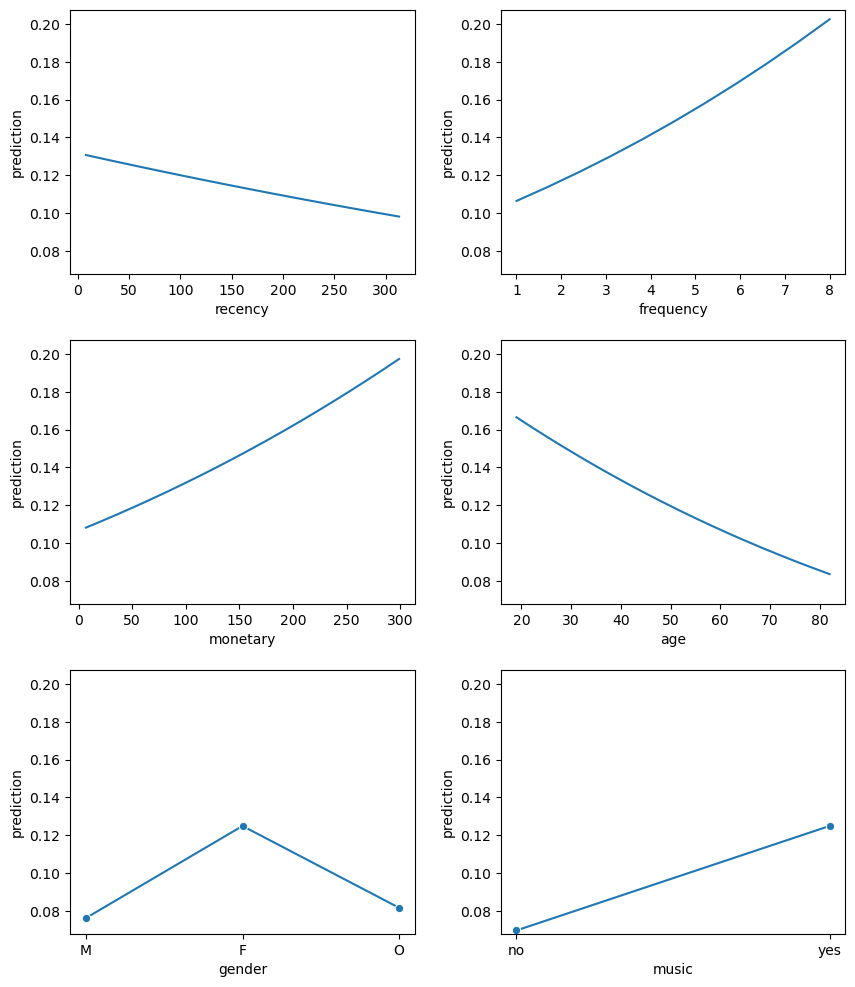

In [88]:
lr.plot('pred')

##### Plotting the full scale of probability (0 to 1)

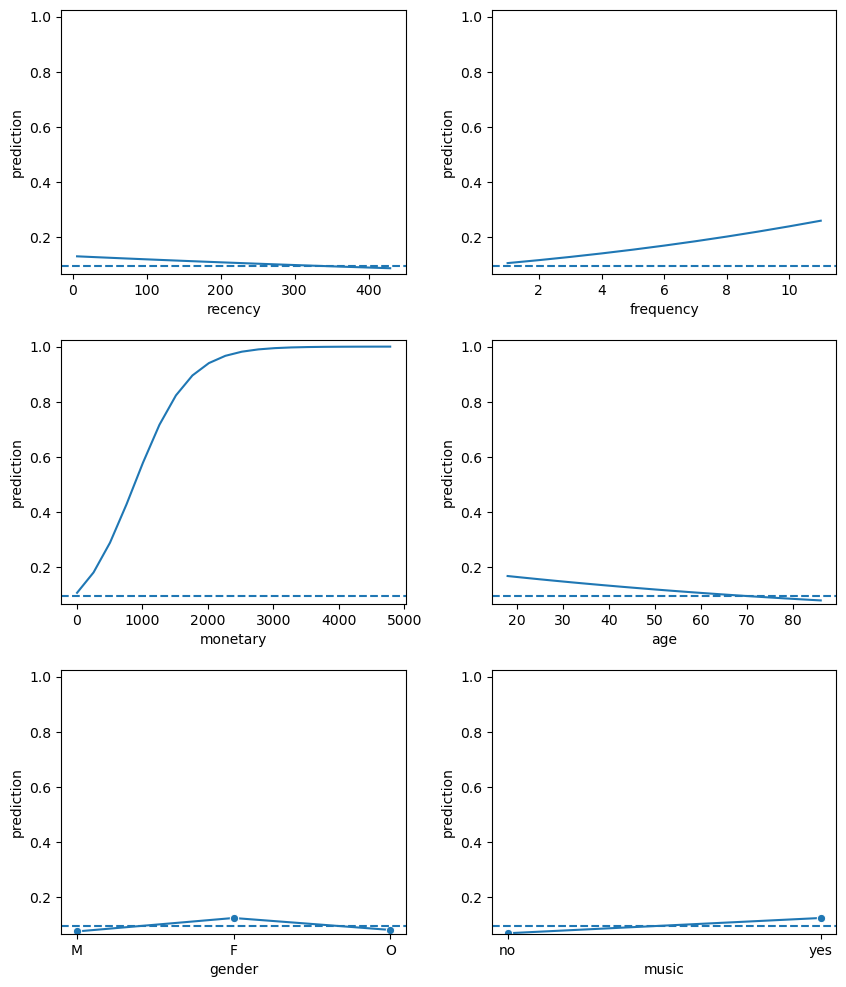

In [89]:
lr.plot('pred',hline=True,minq=0.0,maxq=1.0)

#### Interpretation of the above plots

Recency: <br>
The plot shows a general decreasing trend of purchasing probability as recency increases (i.e. more days have passed since last purchase). This means that customers who recently purchased are more likely to buy the karaoke deal

Frequency: <br>
The plot a general increasing trend of purchasing probability as frequency increases. This suggests that customers who purchase frequently are more likely to purchase the karaoke deal as opposed to those who have an infrequent purchase history

Monetary: <br>
The trend shows that higher average spending per order does seem to motivate purchasing the karaoke deal more. This means that customers who on avg spend more are more likely to buy the karaoke deal

Age: <br>
The plot suggests an inverse relationship of age with probability of purchasing the karaoke deal. Younger customers are more likely to purchase the karaoke deal as compared to the older customers

Gender: <br>
While looking at the first set of plots (without the quartiles specified) the effect of gender seems very visible: females are more likely to purchase the karaoke deal as compared to males or 'other' gender(s). 

Music: <br>
Customers who have previously purchased in the music category show a slightly higher probability of purchasing the karaoke deal - this makes sense as Karaoke would appeal more to those who are generally interested in music

### Question 5

Use Permutation Importance to assess variable importance. Which variables seem to be most important in the model?

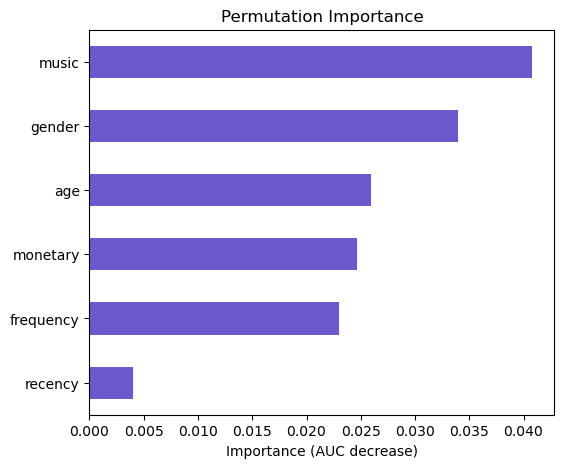

In [90]:
lr.plot('vimp')

Music, gender, age, monetary and frequency seem to be the more important variables with music being the most important in predicting if a customer will purchase the karaoke deal. Recency seems to be the least important explanatory variable and is fairly close to 0 on the importance scale. Elaborating on the concept of permutation importance plots, this basically means that the order of values in the Music, gender, age, monetary and frequency variables is important as it creates meaningful patterns/relationship with the response variable (buyer) which the model makes use of. When we disturb these patterns by shuffling the order of values in these variables/features, the model's performance drops - the more significant the drop, the more important that variable/feature is to the model. 

### Question 6

Add the predicted values from the logistic regression to the "tuango" DataFrame. Use "pred_logit" as the variable name. Compare the average of the predicted values to the overall response rate (i.e., percentage of buyers). What do you notice when you do this calculation using only the data used to estimate the model? Explain.

In [91]:
tuango['pred_logit'] = lr.predict(data=tuango[tuango['test'] == 0])["prediction"] # making predictions on test == 0 data

# comparing the means
avg_prediction_model = tuango['pred_logit'].mean()*100
# overall response rate (as computed before)
overall_response = responders

avg_prediction_model,overall_response

(9.659918589483016, 9.661373636885402)

#### Interpretation
When comparing these two metrics, we can observe that the average predicted probability of a customer purchasing the karaoke deal (according to the logistic regression model) is very close to the actual response rate observed in the data used to estimate the model. This similarity suggests that the model is well-calibrated and provides an average probability estimate that aligns closely with the true proportion of customers who purchased the deal in the test sample.

However, this close match might also indicate that the model is largely predicting the mean/average response rate for all individuals, rather than effectively differentiating between those who are likely to buy and those who are not. This could be a sign of a model that is not capturing the complexities and individual differences within the data, especially given the low pseudo R-squared value that the model generated (keeping the 0.2 - 0.4 range as a good benchmark). 

To summarize, the model's average prediction aligns with the overall response rate but it may not be accurately differentiating between distinct customer behaviors at an individual level - again referencing the low pseudo R-squared value. We may need to add more features or perhaps perform variable transformations to increase the predictive power of the model. 

### Question 7

Estimate a linear regression model using "ordersize" as the response variable and recency, frequency, monetary, age, gender, and music as the explanatory variables. Estimate this regression using only those customers who placed an order after the deal offer message. Describe why you think it does (not) make sense to focus on this group of customers.

In [92]:
# we want to train the model on customers who were part of the sample rollout (5%) and bought the deal -- we want to see if they bought, how big was their basket? How much did they spend? 
tuango_ordersize = tuango_logit[tuango_logit['buyer_yes'] == 1]
print(tuango_ordersize.shape)
tuango_ordersize.head()

(2020, 12)


,userid,buyer,ordersize,recency,frequency,monetary,age,gender,music,training,test,buyer_yes
8,U79932394,yes,4.0,212,1.0,19.900000,59,F,yes,1.0,1,1.0
14,U73924857,yes,5.0,177,10.0,40.000000,41,F,yes,1.0,1,1.0
29,U74007327,yes,5.0,107,1.0,72.000000,26,O,yes,0.0,1,1.0
34,U17047572,yes,3.0,101,4.0,70.000000,56,F,yes,0.0,1,1.0
49,U67414450,yes,4.0,50,1.0,65.599998,20,F,yes,1.0,1,1.0


In [93]:
# train a linear regression model
feature_matrix = ['recency', 'frequency', 'monetary', 'age', 'gender', 'music']
reg = rsm.regress({'tuango_ordersize':tuango_ordersize},rvar='ordersize',evar=feature_matrix)

reg.summary(ssq=True)

Linear regression (OLS)
Data                 : tuango_ordersize
Response variable    : ordersize
Explanatory variables: recency, frequency, monetary, age, gender, music
Null hyp.: the effect of x on ordersize is zero
Alt. hyp.: the effect of x on ordersize is not zero

            coefficient  std.error  t.value p.value     
Intercept         3.665      0.174   21.104  < .001  ***
gender[F]         0.126      0.089    1.425   0.154     
gender[O]         0.259      0.208    1.243   0.214     
music[yes]        0.025      0.097    0.255   0.799     
recency           0.000      0.001    0.591   0.555     
frequency         0.023      0.016    1.456   0.145     
monetary          0.000      0.000    1.035   0.301     
age               0.001      0.003    0.389   0.697     

Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

R-squared: 0.003, Adjusted R-squared: -0.0
F-statistic: 0.939 df(7, 2012), p.value 0.475
Nr obs: 2,020

Sum of squares:

               df     SS
Regres

#### Explanation

The objective is to understand the factors influencing the number of sessions purchased. We are trying to understand that given a customer bought the deal, how much did they buy? This is a different problem than the one being addressed by the logit model where we are trying to predict if a customer buys the karaoke deal yes or no. Given our objective, it is logical to only include those who have made a purchase, as non-buyers do not contribute to understanding the variations in order size.

Targeted Approach: This analysis aims to uncover insights specifically about purchasing behavior in particular how much did a customer buy which is captured in the order size variable. Analyzing only buyers helps isolate and understand the patterns and drivers among those who have already shown an inclination to buy.

Avoiding Skewed Data: Including non-buyers (who would have an order size of zero) could skew the analysis and lead to misleading interpretations about the factors influencing order size.

Model Precision: Focusing on buyers allows for a more precise and accurate model for understanding and predicting order size, as it eliminates the noise that non-buyers would introduce into the model.

However, it's important to note that while this approach is useful for understanding factors affecting order size among buyers, it does not provide insights into what drives customers to make the initial purchase decision - that is a different problem and is being addressed by the logit model. 

While the approach may make sense, I want to share a few thoughts and comments about the model's performance. The R-squared statistic is very low (0.003) meaning only 0.3% of the variation in the ordersize variable can be explained by the explanatory variables we have used which indicates that other factors not included in the model should potentially be included. Moreover, the p-value of all the explanatory variables is >0.05 which indicates that they may not be statistically significant. 

In summary, while the approach may make sense as it directly tackles the question "If they bought, how much did they buy? How much did they spend?" but the model's performance is below par and may not be useful. 

### Question 8

Use Permutation Importance to assess variable importance. Which variables seem to be most important in the model?

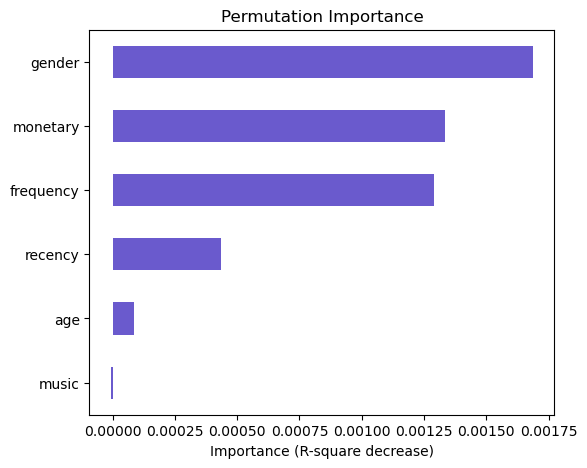

In [94]:
reg.plot('vimp')

Gender, monetary, and frequency seem to be more important in estimating order size while recency, age, and music are less important with music being the least important variable. This is interesting as previously we saw that music is the most important factor for predicting whether a customer will buy the karaoke deal or not. Then again, the two models are answering different questions so this is not unusual. 

### Question 9

What do the linear regression model results suggest about our ability to predict ordersize for customers who responded to the deal?


While the approach may make sense, I want to share a few thoughts and comments about the model's performance. The R-squared statistic is very low (0.003) meaning only 0.3% of the variation in the ordersize variable can be explained by the explanatory variables we have used which indicates that other factors not included in the model should potentially be included. Moreover, the p-value of all the explanatory variables is >0.05 which indicates that they may not be statistically significant. 

In summary, while the approach may make sense as it directly tackles the question "If they bought, how much did they buy? How much did they spend?" but the model's performance is below par and may not be useful. 

### Question 10

Add the predicted values from the linear regression to the "tuango" data.frame. Compare the average of the predicted values to the average value of ordersize. Make sure to focus only on buyers. What do you notice?

In [95]:
pred = reg.predict(data=tuango[tuango['test'] == 0])['prediction']
np.mean(pred)

3.9162322402622727

In [96]:
tuango['pred_linear'] = reg.predict(data=tuango[tuango['test'] == 0])['prediction'] # making predictions on the 397252 customers test == 0
tuango['pred_linear'].mean(),tuango_ordersize['ordersize'].mean()

(3.916232240262273, 3.9410891089108913)

The average predicted order size from the linear regression model, when focused only on buyers, is approximately 3.916. This value is lower than the actual avg ordersize when analyzing data from those customers who were offered the deal and bought it. 

What we notice here is a relatively close approximation between the average predicted and actual order sizes among buyers. This outcome suggests that while the individual predictions for order size (for each customer) might vary, the model, on average, is able to predict with decent accuracy the overall average order size for the group of customers who made a purchase.

However, it's important to remember that this does not necessarily imply that the model is accurate on an individual level. The low R-squared value from the previous analysis indicates that the model's explanatory power for individual variations in order size is quite limited. Therefore, while the model captures the average behavior well, it may not be as effective in predicting individual customer's order sizes when deployed on a larger test data set

## Part III: Profitability Analysis
### Question 11

What is the breakeven response rate? Use the average ordersize from question 2 in your revenue calculations.

In [97]:
# state your assumptions that are relevant to calculate 
# the breakeven response rate
# breakeven should be of type `float`

# assumptions: There is no cost of production as we had in the bbb example. Tuango just takes a share of the karaoke deal revenue without incurring any cost.

cost = 9.0 # this cost here refers to the marginal cost of sending an additional deal message that Liu and her team estimated
selling_price = 49 # indicated in the case study
tuango_share = 0.5 * selling_price
avg_ordersize = q2.loc["yes", "mean"].mean() # using the mean to pull the value -- I can also use min or max since its one value
margin = tuango_share * avg_ordersize
breakeven = cost/margin # float, do not apply rounding, do not express as a percentage
q11 = breakeven # float, DO NOT APPLY ROUNDING, do not express as a percentage
breakeven

0.09320949834524941

The breakeven response rate is approximately 0.0932 based on the avg ordersize. This value represents the minimum proportion of customers who need to respond to the deal offer (i.e., make a purchase) for Tuango to cover the marginal cost of sending an additional deal message.

In other words, at least about 9.32% of the customers to whom the deal message is sent must purchase the deal for the campaign to be financially viable.

#### Plotting a line plot to get a sense of how many customers are above the breakeven point -- remove later

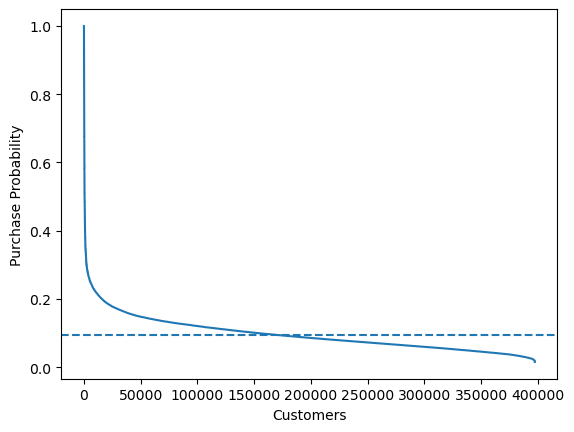

In [98]:
ax = sns.lineplot(y=tuango.pred_logit.sort_values(ascending=False),x = np.arange(tuango.shape[0]))
ax.set(ylabel = 'Purchase Probability')
ax.set(xlabel = 'Customers')
ax.axhline(breakeven,ls='--')

In [99]:
tuango[tuango['buyer_yes'].isna()].shape[0]

397252

In [100]:
np.mean(tuango['buyer_yes'])

0.09661373636885402

### Question 12

What is the projected profit in RMB and the return on marketing expenditures if you offer the deal to all 397,252 remaining customers (i.e., target everyone)?

In [101]:
# insert calculation code here
# all variables should be numeric (integer or float) and of length 1
# _all stands for 'targeting all'
tuango["message_all"] = True

nr_message_all = tuango[tuango['buyer_yes'].isna()].shape[0] # total number of messages that would be sent out
message_cost_all = cost * nr_message_all # total cost of sending messages to selected customers (float)
nr_responses_all = np.mean(tuango['buyer_yes']) * nr_message_all   # total number of positive responses
response_rate_all = nr_responses_all/nr_message_all  # expressed as a proportion (no rounding)
revenue_all = selling_price * (avg_ordersize * nr_responses_all)  # total revenue in RMB (no rounding)
profit_all = 0.5 * revenue_all - message_cost_all   #- total profit in RMB (no rounding)
ROME_all = profit_all/message_cost_all  # Return on Marketing Expenditures expressed as a proportion (no rounding)

ROME_all

0.036522436919414154

In [102]:
display(nr_message_all, message_cost_all, nr_responses_all, response_rate_all, revenue_all, profit_all, ROME_all)

397252

3575268.0

38380.0

0.09661373636885402

7411691.0

130577.5

0.036522436919414154

The return on Marketing Expense is approximately 3.65%

### Question 13

Evaluate the performance implications of offering the deal to only those customers (out of 397,252) with a predicted probability of purchase greater than the breakeven response rate. Determine the projected profit in RMB and the return on marketing expenditures both approaches.

Note: Fine tune your estimate from Q2 above by determining the average amount spent among the people that (1) will receive a message and (2) bought a karaoke deal. Also, use the actual number of messages you plan to send out to the group of customers in the rollout sample (i.e., "test == 0")

In [103]:
tuango['pred_logit'].isna().value_counts()

pred_logit
False    397252
True      20908
Name: count, dtype: int64

In [104]:
tuango['message_logit'] = tuango.pred_logit > breakeven # filtering for only those who are above the breakeven
tuango['message_logit'].shape[0]

418160

In [105]:
tuango[tuango['message_logit']].shape[0]

174126

In [106]:
optimized_avg_ordersize = tuango[tuango['message_logit'] == True]
optimized_avg_ordersize = optimized_avg_ordersize['pred_linear'].mean()
optimized_avg_ordersize

3.9566438209642882

In [107]:
# optimized ordersize based on folks who received the deal and bought the deal
optimized_avg_ordersize = tuango[tuango['message_logit'] == True]
optimized_avg_ordersize = optimized_avg_ordersize['pred_linear'].mean()

nr_message_logit = tuango[tuango['message_logit']].shape[0] # total number of messages that would be sent out
message_cost_logit = cost*nr_message_logit # total cost of sending messages to selected customers (float)
nr_responses_logit = tuango[tuango['message_logit']]['pred_logit'].mean() * nr_message_logit # total number of positive responses
response_rate_logit = nr_responses_logit / nr_message_logit # expressed as a proportion (no rounding)
revenue_logit = selling_price * (optimized_avg_ordersize * nr_responses_logit) # total revenue in RMB (no rounding)
profit_logit = 0.5 * revenue_logit - message_cost_logit # 0.5 * revenue - message_cost #- total profit in RMB (no rounding)
ROME_logit = profit_logit/message_cost_logit # Return on Marketing Expenditures expressed as a proportion (no rounding)

ROME_logit

0.5118897340732692

In [108]:
display(nr_message_logit, message_cost_logit, nr_responses_logit, response_rate_logit, revenue_logit, profit_logit, ROME_logit)

174126

1567134.0

24441.801355587948

0.14036847659504006

4738667.613034357

802199.8065171787

0.5118897340732692

### Question 14

Create a bar chart with profit information for the analyses conducted in questions 12 and 13

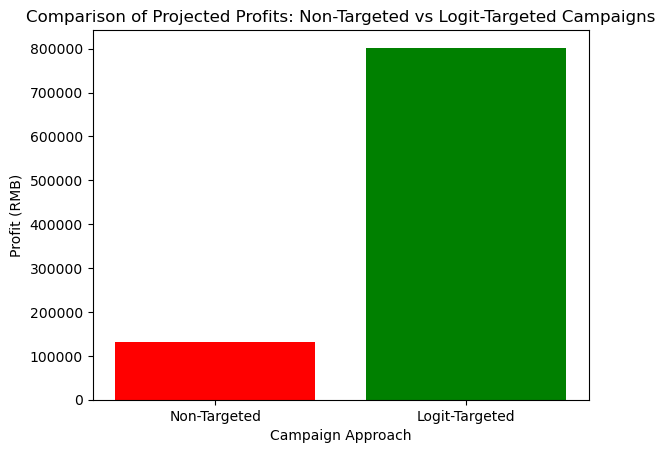

In [109]:
methods = ['Non-Targeted', 'Logit-Targeted']
profits = [profit_all, profit_logit]

# Creating the bar chart
plt.bar(methods, profits, color=['red', 'green'])
plt.xlabel('Campaign Approach')
plt.ylabel('Profit (RMB)')
plt.title('Comparison of Projected Profits: Non-Targeted vs Logit-Targeted Campaigns')
plt.show()

### Question 15

Create a bar chart with ROME for the analyses conducted in questions 12 and 13

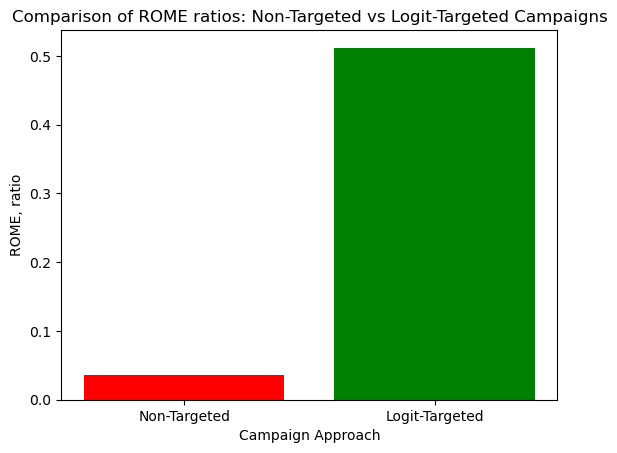

In [110]:
methods = ['Non-Targeted', 'Logit-Targeted']
profits = [ROME_all, ROME_logit]

# Creating the bar chart
plt.bar(methods, profits, color=['red', 'green'])
plt.xlabel('Campaign Approach')
plt.ylabel('ROME, ratio')
plt.title('Comparison of ROME ratios: Non-Targeted vs Logit-Targeted Campaigns')
plt.show()

### Question 16

You also have access to a dataset with the results from the deal offer roll-out (tuango_post.parquet). Tuango decided to contact all remaining 397,252 customers because this would provide data that could be used to evaluate different targeting approaches. The data has a "test" variable (test = 1 for the data used in the test, test = 0 for the remaining customers). You can use this variable to help evaluate the actual performance for the targeting approaches evaluated in questions 12 and 13. Re-create the plots from question 14 and 15 based on this new dataset.

Copy your tuango-pre.ipynb file to a new file tuango-post.ipynb. Instead of using the tuango_pre.parquet data, load tuango_post.parquet. You should be able to re-use most of your code and text. Calculate the actual performance for both targeting approach on the 'roll out' sample (i.e., test == 0).

Hint 1: It is important that you do NOT use any information about buyers that were in the 'roll out' sample (i.e., test == 0) when calculating the break-even response rate etc. for targeting.

Hint 2: You have the actual data on what happened in the "post" data. Use that information to calculate performance (i.e., do not "project" the performance like you had to do for questions 12 and 13).



### Question 17

Please describe how you used Generative AI-tools like ChatGPT to support your work on this assignment. Provide pdfs and/or screenshots of your “discussions” with these tools and comment on what things did and did not go well. Also add any questions you may have about the assignment and the support you received from GenAI so we can discuss these topics in class.

Note: No matter how you used Generative AI-tools, you will be expected to fully understand all elements of the assignment. You may be called on in class to walk us through your thought process and how different parts of your code work. 
